# Overview #

## TODO##

 1. Implement host Python class API to wrap DMA ADC scanning mechanism
    described in [this notebook][1].
 2. Implement device C++ class API to wrap DMA ADC scanning mechanism
    described in [this notebook][1].

[1]: Example%20-%20Periodic%20multi-channel%20ADC%20multiple%20samples%20using%20DMA.ipynb

# Device

### Connect to device

In [1]:
import re

import numpy as np
import pandas as pd
import arduino_helpers.hardware.teensy.adc as adc
import arduino_helpers.hardware.teensy as teensy
from arduino_rpc.protobuf import resolve_field_values
from teensy_minimal_rpc import SerialProxy
import teensy_minimal_rpc.DMA as DMA
import teensy_minimal_rpc.ADC as ADC
import teensy_minimal_rpc.SIM as SIM
import teensy_minimal_rpc.PIT as PIT


def get_pdb_divide_params(frequency, F_BUS=int(48e6)):
    mult_factor = np.array([1, 10, 20, 40])
    prescaler = np.arange(8)

    clock_divide = (pd.DataFrame([[i, m, p, m * (1 << p)]
                                  for i, m in enumerate(mult_factor)
                                  for p in prescaler],
                                 columns=['mult_', 'mult_factor',
                                          'prescaler', 'combined'])
                    .drop_duplicates(subset=['combined'])
                    .sort_values('combined', ascending=True))
    clock_divide['clock_mod'] = (F_BUS / frequency
                                 / clock_divide.combined).astype(int)
    return clock_divide.loc[clock_divide.clock_mod <= 0xffff]


DMAMUX_SOURCE_ADC0 = 40  # from `kinetis.h`
DMAMUX_SOURCE_ADC1 = 41  # from `kinetis.h`
DMAMUX_SOURCE_PDB = 48  # from `kinetis.h`
ADC0_SC1A = 0x4003B000  # ADC status and control registers 1
ADC0_RA = 0x4003B010  # ADC data result register
ADC0_RB = 0x4003B014  # ADC data result register
    
SC1A_PINS = pd.Series(dict([(v, adc.CHANNEL_TO_SC1A_ADC0[getattr(teensy, v)])
                            for v in dir(teensy) if re.search(r'^A\d+', v)]))
HW_TCDS_ADDR = 0x40009000

PDB0_IDLY = 0x4003600C  # Interrupt Delay Register
PDB0_SC = 0x40036000  # Status and Control Register
PDB0_MOD = 0x40036004  # Modulus Register

PDB_SC_PDBEIE = 0x00020000  # Sequence Error Interrupt Enable
PDB_SC_SWTRIG = 0x00010000  # Software Trigger
PDB_SC_DMAEN = 0x00008000  # DMA Enable
PDB_SC_PDBEN = 0x00000080  # PDB Enable
PDB_SC_PDBIF = 0x00000040  # PDB Interrupt Flag
PDB_SC_PDBIE = 0x00000020  # PDB Interrupt Enable.
PDB_SC_CONT = 0x00000002  # Continuous Mode Enable
PDB_SC_LDOK = 0x00000001  # Load OK


def PDB_SC_TRGSEL(n): return (((n) & 15) << 8)  # Trigger Input Source Select
def PDB_SC_PRESCALER(n): return (((n) & 7) << 12)  # Prescaler Divider Select
def PDB_SC_MULT(n): return (((n) & 3) << 2)  # Multiplication Factor
def PDB_SC_LDMOD(n): return (((n) & 3) << 18)  # Load Mode Select


class AdcSampler(object):
    def __init__(self, proxy, channels, sample_count,
                 dma_channels=None, adc_number=teensy.ADC_0):
        self.proxy = proxy
        self.channels = channels
        # The number of samples to record for each ADC channel.
        self.sample_count = sample_count
        if dma_channels is None:
            dma_channels = pd.Series([0, 1, 2],
                                     index=['scatter', 'i', 'ii'])
        self.dma_channels = dma_channels
        self.adc_number = adc_number 

        # Map Teensy analog channel labels to channels in
        # `ADC_SC1x` format.
        self.channel_sc1as = np.array(SC1A_PINS[channels].tolist(),
                                      dtype='uint32')
        
        # Enable PDB clock (DMA and ADC clocks should already be enabled).
        self.proxy.update_sim_SCGC6(SIM.R_SCGC6(PDB=True))
        
        self.allocate_device_arrays()
        self.reset()
        
        self.configure_adc()
        self.configure_timer(1)
        
        self.configure_dma_channel_ii_mux()
        self.assert_no_dma_error()
        
        self.configure_dma_channel_scatter()
        self.assert_no_dma_error()
        
        self.configure_dma_channel_i()
        self.assert_no_dma_error()
        
        self.configure_dma_channel_ii()
        self.assert_no_dma_error()
        
        self.configure_dma_channel_i_mux()
        self.assert_no_dma_error()
    
    def assert_no_dma_error(self):
        df_dma_registers = self.proxy.DMA_registers()
        assert(df_dma_registers.loc[df_dma_registers
                                    .full_name == 'ERR',
                                    'value'].sum() == 0)
        
    def allocate_device_arrays(self):
        # Calculate total number of bytes for single scan of ADC channels.
        self.N = np.dtype('uint16').itemsize * self.channel_sc1as.size
        
        # Use series to store all allocations.  This makes it easy
        # to, e.g., free allocated device memory on clean up.
        self.allocs = pd.Series()
        
        # Allocate device memory for results from single ADC scan.
        self.allocs['scan_result'] = self.proxy.mem_alloc(self.N)
        
        # Allocate and copy channel SC1A configurations to device memory.
        self.allocs['sc1as'] = \
            (self.proxy
             .mem_aligned_alloc_and_set(4,
                                        self.channel_sc1as
                                        .view('uint8')))

        # Allocate device memory for sample buffer for each
        # ADC channel.
        self.allocs['samples'] = \
            self.proxy.mem_alloc(self.sample_count * self.N)

        # Allocate device memory for DMA TCD configurations.
        # __N.B.,__ Transfer control descriptors are 32 bytes each
        # and MUST be aligned to 0-modulo-32 address.
        self.allocs['tcds'] = \
            self.proxy.mem_aligned_alloc(32, self.sample_count * 32)
        # Store list of device TCD configuration addresses.
        self.tcd_addrs = [self.allocs.tcds + 32 * i
                          for i in xrange(self.sample_count)]
        # Store list of device TCD register addresses.
        # __N.B.,__ There are 16 DMA channels on the device.
        # __TODO__ Query `proxy` to determine number of DMA channels.
        self.hw_tcd_addrs = [HW_TCDS_ADDR + 32 * i
                             for i in xrange(16)]

    def reset(self):
        # Fill result arrays with zeros
        self.proxy.mem_fill_uint8(self.allocs.scan_result, 0, self.N)
        self.proxy.mem_fill_uint8(self.allocs.samples, 0,
                                  self.sample_count * self.N)
        
    def configure_dma_channel_scatter(self):
        # Create Transfer Control Descriptor configuration for first chunk, encoded
        # as a Protocol Buffer message.
        tcd0_msg = DMA.TCD(CITER_ELINKNO=DMA.R_TCD_ITER_ELINKNO(ITER=1),
                           BITER_ELINKNO=DMA.R_TCD_ITER_ELINKNO(ITER=1),
                           ATTR=DMA.R_TCD_ATTR(SSIZE=DMA.R_TCD_ATTR._16_BIT,
                                               DSIZE=DMA.R_TCD_ATTR._16_BIT),
                           NBYTES_MLNO=self.N,
                           SADDR=int(self.allocs.scan_result),
                           SOFF=2,
                           SLAST=-self.N,
                           DADDR=int(self.allocs.samples),
                           DOFF=2 * self.sample_count,
                           DLASTSGA=int(self.tcd_addrs[1]),
                           CSR=DMA.R_TCD_CSR(START=0, DONE=False, ESG=True))

        # Convert Protocol Buffer encoded TCD to bytes structure.
        tcd0 = self.proxy.tcd_msg_to_struct(tcd0_msg)

        # Create binary TCD struct for each TCD protobuf message and copy to device
        # memory.
        for i in xrange(self.sample_count):
            tcd_i = tcd0.copy()
            tcd_i['SADDR'] = self.allocs.scan_result
            tcd_i['DADDR'] = self.allocs.samples + 2 * i
            tcd_i['DLASTSGA'] = self.tcd_addrs[(i + 1)
                                               % len(self.tcd_addrs)]
            tcd_i['CSR'] |= (1 << 4)
            if i == (self.sample_count - 1):  # Last sample, so trigger major loop interrupt
                tcd_i['CSR'] |= (1 << 1)  # Set `INTMAJOR` (21.3.29/426)
            self.proxy.mem_cpy_host_to_device(self.tcd_addrs[i],
                                              tcd_i.tostring())

        # Load initial TCD in scatter chain to DMA channel chosen to handle scattering.
        self.proxy.mem_cpy_host_to_device(self.hw_tcd_addrs
                                          [self.dma_channels.scatter],
                                          tcd0.tostring())
        self.proxy.attach_dma_interrupt(self.dma_channels.scatter)
        
    def configure_dma_channel_i(self):
        sca1_tcd_msg =\
            DMA.TCD(CITER_ELINKNO=
                    DMA.R_TCD_ITER_ELINKNO(ELINK=False,
                                           ITER=self.channel_sc1as.size),
                    BITER_ELINKNO=
                    DMA.R_TCD_ITER_ELINKNO(ELINK=False,
                                           ITER=self.channel_sc1as.size),
                    ATTR=DMA.R_TCD_ATTR(SSIZE=DMA.R_TCD_ATTR._32_BIT,
                                        DSIZE=DMA.R_TCD_ATTR._32_BIT),
                    NBYTES_MLNO=4,  # `SDA1` register is 4 bytes (32-bit)
                    SADDR=int(self.allocs.sc1as),
                    SOFF=4,
                    SLAST=-self.channel_sc1as.size * 4,
                    DADDR=int(ADC0_SC1A),
                    DOFF=0,
                    DLASTSGA=0,
                    CSR=DMA.R_TCD_CSR(START=0, DONE=False))

        self.proxy.update_dma_TCD(self.dma_channels.i, sca1_tcd_msg)
        
    def configure_dma_channel_i_mux(self):
        self.proxy.update_dma_mux_chcfg(self.dma_channels.i,
                                        DMA.MUX_CHCFG(SOURCE=
                                                      DMAMUX_SOURCE_PDB,
                                                      TRIG=False,
                                                      ENBL=True))
        self.proxy.update_dma_registers(
            DMA.Registers(SERQ=int(self.dma_channels.i)))
        
    def configure_adc(self):
        # Select B input for ADC MUX.
        self.proxy.update_adc_registers(
            self.adc_number,
            ADC.Registers(CFG2=ADC.R_CFG2(MUXSEL=ADC.R_CFG2.B)))
        
    def configure_timer(self, sample_rate_hz):
        # Set PDB interrupt to occur when IDLY is equal to CNT + 1.
        # PDB0_IDLY = 1
        self.proxy.mem_cpy_host_to_device(PDB0_IDLY,
                                          np.uint32(1).tostring())

        clock_divide = get_pdb_divide_params(sample_rate_hz).iloc[0]
        
        # PDB0_MOD = (uint16_t)(mod-1);
        self.proxy.mem_cpy_host_to_device(PDB0_MOD,
                                          np.uint32(clock_divide
                                                    .clock_mod)
                                          .tostring())

        PDB_CONFIG = (PDB_SC_TRGSEL(15)  # Software trigger
                      | PDB_SC_PDBEN  # Enable PDB
                      | PDB_SC_CONT  # Continuous
                      | PDB_SC_LDMOD(0)
                      | PDB_SC_PRESCALER(clock_divide.prescaler)
                      | PDB_SC_MULT(clock_divide.mult_)
                      | PDB_SC_DMAEN  # Enable DMA
                      | PDB_SC_LDOK)  # Load all new values
        self.proxy.mem_cpy_host_to_device(PDB0_SC,
                                          np.uint32(PDB_CONFIG)
                                          .tostring())
        return PDB_CONFIG

    def configure_dma_channel_ii_mux(self):
        ### Set DMA mux source for channel to ADC0 ###
        self.proxy.update_dma_mux_chcfg(
            self.dma_channels.ii,
            DMA.MUX_CHCFG(
                # Route ADC0 as DMA channel source.
                SOURCE=DMAMUX_SOURCE_ADC0,
                TRIG=False,# Disable periodic trigger.
                # Enable the DMAMUX configuration for channel.
                ENBL=True))
        self.proxy.enableDMA(teensy.ADC_0)
        
    def configure_dma_channel_ii(self):
        tcd_msg = \
            DMA.TCD(CITER_ELINKYES=
                    DMA.R_TCD_ITER_ELINKYES(ELINK=True,
                                            LINKCH=1,
                                            ITER=self.channel_sc1as.size),
                    BITER_ELINKYES=
                    DMA.R_TCD_ITER_ELINKYES(ELINK=True,
                                            LINKCH=1,
                                            ITER=self.channel_sc1as.size),
                    ATTR=DMA.R_TCD_ATTR(SSIZE=DMA.R_TCD_ATTR._16_BIT,
                                        DSIZE=DMA.R_TCD_ATTR._16_BIT),
                    NBYTES_MLNO=2,  # sizeof(uint16)
                    SADDR=ADC0_RA,
                    SOFF=0,
                    SLAST=0,
                    DADDR=int(self.allocs.scan_result),
                    DOFF=2,
                    DLASTSGA=-self.N,
                    CSR=DMA.R_TCD_CSR(START=0, DONE=False,
                                      # Start `scatter` DMA channel
                                      # after completion of major loop.
                                      MAJORELINK=True,
                                      MAJORLINKCH=
                                      int(self.dma_channels.scatter)))

        self.proxy.update_dma_TCD(self.dma_channels.ii, tcd_msg)

        # DMA request input signals and this enable request flag
        # must be asserted before a channel’s hardware service
        # request is accepted (21.3.3/394).
        #    DMA_SERQ = i
        self.proxy.update_dma_registers(
            DMA.Registers(SERQ=int(self.dma_channels.ii)))
    
    def start_read(self, sample_rate_hz):
        '''
        Trigger start of ADC sampling at the specified sampling rate.
        '''
        self.proxy.attach_dma_interrupt(self.dma_channels.scatter)
        clock_divide = get_pdb_divide_params(sample_rate_hz).iloc[0]
        pdb_config = self.configure_timer(sample_rate_hz)
        pdb_config |= PDB_SC_SWTRIG  # Start the counter.
        
        # Copy configured PDB register state to device hardware register.
        self.proxy.mem_cpy_host_to_device(PDB0_SC,
                                          np.uint32(pdb_config)
                                          .tostring())
        
        # **N.B.,** Timer will be stopped by the scatter DMA channel major loop interrupt
        # handler after `sample_count` samples have been collected.
    
    def __dealloc__(self):
        self.allocs[['scan_result', 'samples']].map(self.proxy.mem_free)
        self.allocs[['sc1as', 'tcds']].map(self.proxy.mem_aligned_free)
        
    def get_results(self):
        data = proxy.mem_cpy_device_to_host(self.allocs.samples,
                                            self.sample_count * self.N)
        df_adc_results = pd.DataFrame(data.view('uint16')
                                      .reshape(-1, self.sample_count).T,
                                      columns=self.channels)
        return df_adc_results 

In [40]:
# Disconnect from existing proxy (if available)
try:
    del adc_sampler
    del proxy
except NameError:
    pass

proxy = SerialProxy()
proxy.pin_mode(teensy.LED_BUILTIN, 1)
proxy.free_all()

channels = ['A0']

# Set ADC parameters
proxy.setAveraging(4, teensy.ADC_0)
proxy.setResolution(10, teensy.ADC_0)
proxy.setConversionSpeed(teensy.ADC_HIGH_SPEED, teensy.ADC_0)
proxy.setSamplingSpeed(teensy.ADC_HIGH_SPEED, teensy.ADC_0)
proxy.update_adc_registers(
    teensy.ADC_0,
    ADC.Registers(CFG2=ADC.R_CFG2(MUXSEL=ADC.R_CFG2.B)))

adc_sampler = AdcSampler(proxy, channels, 20)

In [41]:
adc_sampler.reset()
adc_sampler.start_read(20e3)

In [27]:
%matplotlib inline

Samples by channel:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
A0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


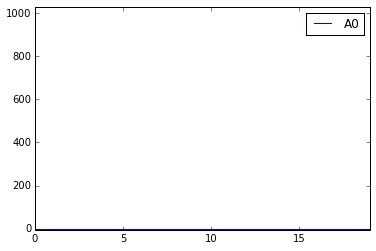

In [42]:
print 'Samples by channel:'
df_adc_results = adc_sampler.get_results()
df_adc_results.plot(ylim=(-5, 1030))
df_adc_results.T